# Introduction

This notebook is designed to create figures for my paper

# Set-Up

In [11]:
# set up
from google.colab import drive
drive.mount('/content/drive')

%run '/content/drive/My Drive/hPSC-FAIRness Analysis/scripts/setup_drive.py'

root_dir, data_dir, processed_dir, results_dir = setup_drive()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive
Setting up root directory with name: 'hPSC-FAIRness Analysis'
Root directory path: '/content/drive/My Drive/hPSC-FAIRness Analysis'


* Load packages

In [12]:
pip install upsetplot pandas

In [13]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from upsetplot import UpSet
import ast

* Load Dataframe

In [14]:
# Before country rescue
#df = pd.read_excel(os.path.join(processed_dir,'Registration & Banking Status.xlsx'))

# Load hPSCs after country rescue
df = pd.read_excel(os.path.join(processed_dir,'Final.xlsx'))
df.info()

# Load Infrastructure Lookup Table
lookup_df = pd.read_excel(os.path.join(results_dir, 'Infrastructure Lookup Table.xlsx'))
lookup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21674 entries, 0 to 21673
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   AC                    21674 non-null  object
 1   ID                    21674 non-null  object
 2   CA                    21674 non-null  object
 3   DR                    21627 non-null  object
 4   DT                    21674 non-null  object
 5   OX                    21674 non-null  object
 6   CC                    21653 non-null  object
 7   SX                    20936 non-null  object
 8   AG                    20178 non-null  object
 9   SY                    15411 non-null  object
 10  RX                    11675 non-null  object
 11  DI                    10510 non-null  object
 12  OI                    6814 non-null   object
 13  HI                    5341 non-null   object
 14  WW                    2144 non-null   object
 15  ST                    1213 non-null 

# Figures - status of banking and registration by country

## Methods

### Step 1: Statistics for Registration and Banking Status

Define a function to create a DataFrame that counts the statistics of registration and banking status of hPSCs by country. The 'attri' parameter in this function can be susbtitude to 'Registered', 'Banked', or 'Registered or Banked' to specify the status being analyzed.

In [15]:

def counts(df, geo, attri):
    # Count the occurrences of 'True' and 'False' for the specified attribute, grouped by country
    # Can be group by either 'Country' or 'Region'
    counts = df.groupby([geo, attri]).size().unstack(fill_value=0)

    # Create a label for 'Not <attribute>' to record the count of cases that do not meet the attribute condition
    not_attri = 'Not ' + attri

    # Rename columns for clarity: one for the attribute and one for the 'Not' attribute
    counts = counts.rename(columns={True: attri, False: not_attri})

    # Calculate the total number of cell lines for each country by summing the counts of the attribute and non-attribute
    counts['Total'] = counts[attri] + counts[not_attri]

    # Calculate the percentage of cell lines that meet the attribute condition
    counts['%' + attri] = (counts[attri] / counts['Total'] * 100).round(2)

    # Sort the DataFrame by the total number of cell lines in descending order
    counts = counts.sort_values(by='Total', ascending=False)

    return counts

### Step 2: Histogram Function

Define a function to create a histogram for statistics of banking and registration status derived from **Step 1**

In [16]:
# Define a function draws histogram for counts results
# write a function that draw histogram
def histogram(df, attri):
  # Plotting
  # when plotting all countries
  plt.figure(figsize=(7, 5))
  # when plotting fewer countries
  #plt.figure(figsize=(8, 8))

  # Plot when attribute is yes
  plt.bar(df.index, df[attri], color='steelblue', label=attri)
  # add numbers on each bar
  for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.0f}',
        ha='center',
        va='bottom',
        rotation=45,
        fontsize=12
    )
  # Plot when attribute is no
  plt.bar(df.index, df['Not ' +  attri], bottom=df[attri], color='lightgrey', label='Not ' +  attri)

  # Replace 'USA' with 'US' in the tick labels
  new_labels = ['US' if label == 'USA' else label for label in count.index]
  plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=45, ha='right')

  # Remove the top and right spines
  ax = plt.gca()
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  plt.xlabel('Country')
  plt.ylabel('Number of Cell Lines')
  #plt.title('hPSCs '+attri + 'Status by Country')
  plt.xticks(rotation=45, ha='right')
  plt.legend()
  plt.tight_layout()
  plt.show()






## Results

### Overview

In [17]:
def histogram(df, attri, size, color, ax=None, legend_label=None):
    countries_to_keep = ['US', 'Europe', 'Japan', 'Australia']
    df = df.rename(index={'USA': 'US'})
    df_filtered = df.loc[df.index.intersection(countries_to_keep)]
    df_filtered = df_filtered.rename(index={
        'Europe': 'EU/UK',
        'Japan': 'JP',
        'Australia': 'AU'
    })

    # If no ax is given, use current axis
    if ax is None:
        ax = plt.gca()

    # Use custom label if provided, otherwise default to attri
    main_label = legend_label if legend_label else attri

    # Plot main bars with label for legend
    bars = ax.bar(
        df_filtered.index,
        df_filtered[attri],
        color=color,
        label=main_label  # This will be shown in the legend
    )

    # Plot grey bars WITHOUT label (so they won’t show in legend)
    ax.bar(
        df_filtered.index,
        df_filtered['Not ' + attri],
        bottom=df_filtered[attri],
        color='lightgrey'
        # no label here
    )

    # Add text on bars
    '''
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.0f}',
            ha='center',
            va='bottom',
            rotation=45,
            fontsize=12
        )'''

    # Labels and ticks
    #ax.set_xlabel('Country', fontsize=14)
    #ax.set_ylabel('Number of Cell Lines', fontsize=14)
    ax.set_xticks(range(len(df_filtered.index)))
    ax.set_xticklabels(df_filtered.index, fontsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Show only the main label in the legend
    ax.legend(loc = 'upper right', fontsize=4.7)


<ipython-input-18-5810b44d092d>:34: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig("registration_by_region.png", dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


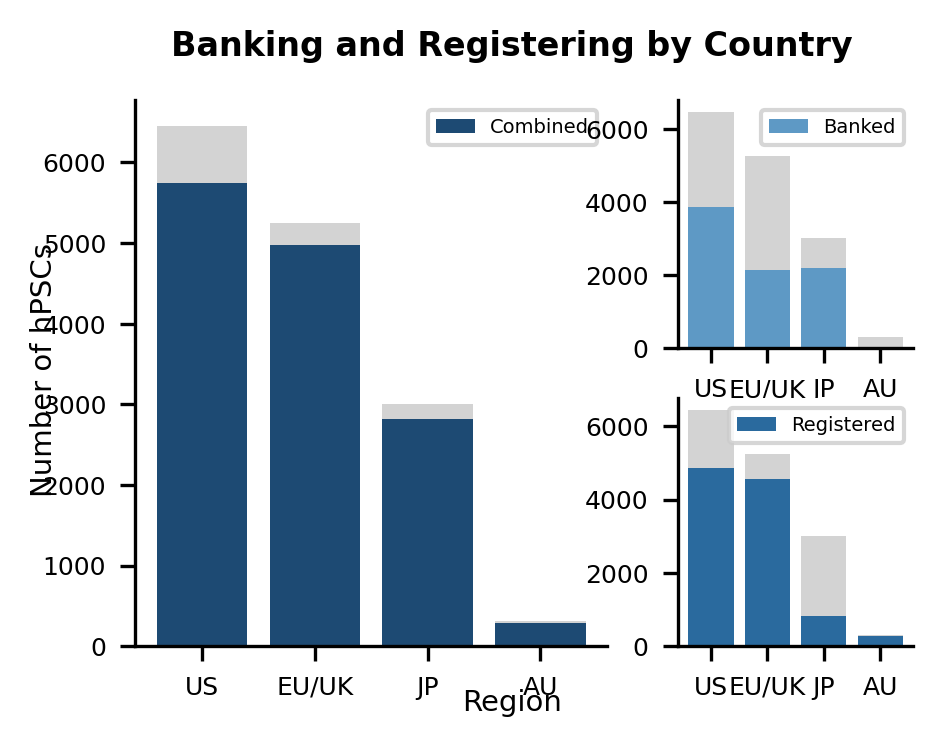

In [18]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# --- Fixed figure size in mm ---
fig_width_inch = 85 / 25.4
fig_height_inch = 60 / 25.4

# --- Prepare data ---
count1 = counts(df, 'Region', 'Registered or Banked')
count2 = counts(df, 'Region', 'Banked')
count3 = counts(df, 'Region', 'Registered')

# --- Create figure with constrained layout ---

fig = plt.figure(figsize=(fig_width_inch, fig_height_inch), dpi=300, constrained_layout=True)
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])  # Left column twice as wide

# --- Subplots ---
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

# --- Plot each histogram ---
histogram(count1, 'Registered or Banked', (4, 3.5), '#1D4A73', ax=ax1, legend_label='Combined')
histogram(count2, 'Banked', (4.5, 3.5), '#5E99C5', ax=ax2)
histogram(count3, 'Registered', (4.5, 7), '#2A6A9E', ax=ax3)

# --- Global title and axis labels ---
fig.suptitle('Banking and Registering by Country', fontsize=8, fontweight='bold')
fig.supxlabel('Region', fontsize=7)
fig.supylabel('Number of hPSCs', fontsize=7)

# --- Save to file (optional) ---
fig.savefig("registration_by_region.png", dpi=300)

# --- Show the plot ---
plt.show()


### Registration Status

Banked status by country

# Figures - Upset Plots

In [19]:
#df['Published'] = df['RX'].apply(lambda x: False if pd.isna(x) or x == '' else True)


Transformed Data for UpSet Plot:
Published  Registered  Banked
False      False       False      703
                       True      2808
           True        False     2845
                       True      3643
True       False       False     4466
                       True       613
           True        False     5256
                       True      1340
Name: Count, dtype: int64
Published  Registered  Banked
False      False       False      3.243518
                       True      12.955615
           True        False     13.126326
                       True      16.808157
True       False       False     20.605334
                       True       2.828274
           True        False     24.250254
                       True       6.182523
Name: Count, dtype: float64


<ipython-input-20-e33f47728b11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Count'] = 1
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/d

<Figure size 2700x1500 with 0 Axes>

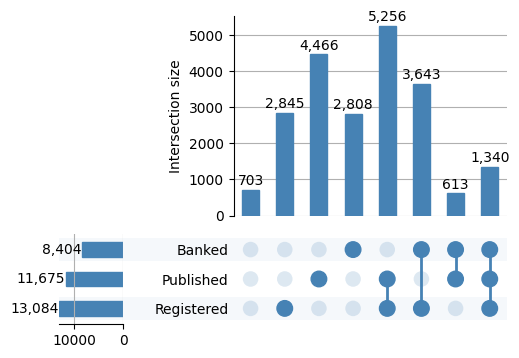

In [20]:
from upsetplot import generate_counts, plot
df_subset = df[['Published', 'Registered', 'Banked']]

# Convert the selected columns into a MultiIndex and count occurrences
df_subset['Count'] = 1

df_subset = df_subset.groupby(['Published', 'Registered', 'Banked']).size()
df_subset.name = 'Count'
df_subset = df_subset.reset_index().set_index(['Published', 'Registered', 'Banked'])['Count']

# Convert counts to percentages
total_count = df_subset.sum()
df_subset_percentage = (df_subset / total_count) * 100

print("\nTransformed Data for UpSet Plot:")
print(df_subset)
print(df_subset_percentage)

plt.figure(figsize=(9, 5), dpi=300)

plot(df_subset, facecolor = 'steelblue', show_counts="{:,}", sort_by="degree")
#plt.suptitle("Ordered by degree")

plt.show()

/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

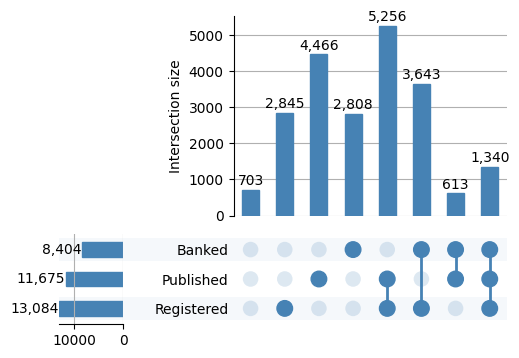

In [21]:
plot(df_subset, facecolor = 'steelblue', show_counts="{:,}", sort_by="degree")
#plt.suptitle("Ordered by degree")
plt.show()

/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

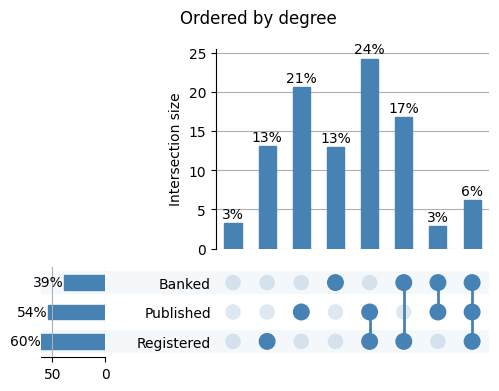

In [22]:
plot(df_subset_percentage, facecolor = 'steelblue', show_counts = '%.0f%%', sort_by="degree")
plt.suptitle("Ordered by degree")
plt.show()

In [23]:
df_agg = df[['Published', 'Registered or Banked']]

# Convert the selected columns into a MultiIndex and count occurrences
df_agg['Count'] = 1

df_agg = df_agg.groupby(['Published', 'Registered or Banked']).size()
df_agg.name = 'Count'
df_agg = df_agg.reset_index().set_index(['Published', 'Registered or Banked'])['Count']

# Convert counts to percentages
total_count = df_agg.sum()
df_agg_percentage = (df_agg / total_count) * 100

print("\nTransformed Data for UpSet Plot:")
print(df_agg)
print(df_agg_percentage)


Transformed Data for UpSet Plot:
Published  Registered or Banked
False      False                    703
           True                    9296
True       False                   4466
           True                    7209
Name: Count, dtype: int64
Published  Registered or Banked
False      False                    3.243518
           True                    42.890099
True       False                   20.605334
           True                    33.261050
Name: Count, dtype: float64


<ipython-input-23-5d719c386de1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg['Count'] = 1


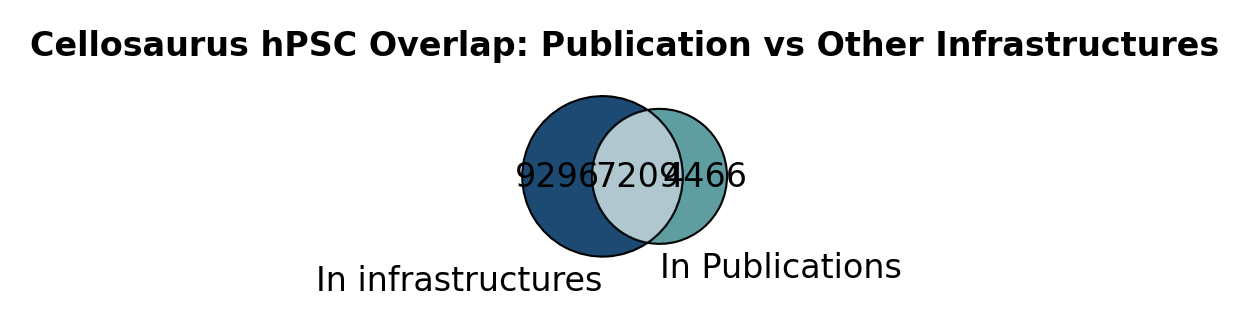

In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Assume df has columns: 'Published', 'Registered or Banked'
df_agg = df[['Published', 'Registered or Banked']].copy()
df_agg['Count'] = 1

# Aggregate counts
grouped = df_agg.groupby(['Published', 'Registered or Banked']).size()
grouped.name = 'Count'
grouped = grouped.reset_index().set_index(['Published', 'Registered or Banked'])['Count']

# Extract counts for Venn diagram
only_published = grouped.get((True, False), 0)
only_registered = grouped.get((False, True), 0)
both = grouped.get((True, True), 0)

# Total for percentage calc (if needed)
total = only_published + only_registered + both


# ---- VENN DIAGRAM ----
# Set figure size
fig_width_inch = 160 / 25.4
fig_height_inch = 30 / 25.4

fig, ax = plt.subplots(figsize=(fig_width_inch, fig_height_inch), dpi = 300)
ax.set_aspect(0.5)

venn = venn2(subsets=( only_registered, only_published, both),
             set_labels=('In infrastructures', 'In Publications'),
             ax=ax)

# Optional: format for publication-quality
for text in venn.set_labels:
    text.set_fontsize(8)
    #text.set_fontweight('bold')

for text in venn.subset_labels:
    if text:  # sometimes subset label can be None
        text.set_fontsize(8)

# Optional: custom colors
venn.get_patch_by_id('10').set_color('#1D4A73')  # Published only
venn.get_patch_by_id('10').set_alpha(1.0)        # Remove transparency

venn.get_patch_by_id('01').set_color('cadetblue')  # Registered only
venn.get_patch_by_id('01').set_alpha(1.0)        # Remove transparency

venn.get_patch_by_id('11').set_color('#3E7489')  # Both

# Set black edges for all Venn regions
for subset_id in ['10', '01', '11']:
    patch = venn.get_patch_by_id(subset_id)
    if patch:
        patch.set_edgecolor('black')
        patch.set_linewidth(0.5)  # You can increase this if needed

# Improve aesthetics
plt.title('Cellosaurus hPSC Overlap: Publication vs Other Infrastructures', ha='center', fontsize=8, fontweight='bold')

plt.tight_layout()
#lt.savefig("venn_publication_quality.png", dpi=300)
plt.show()


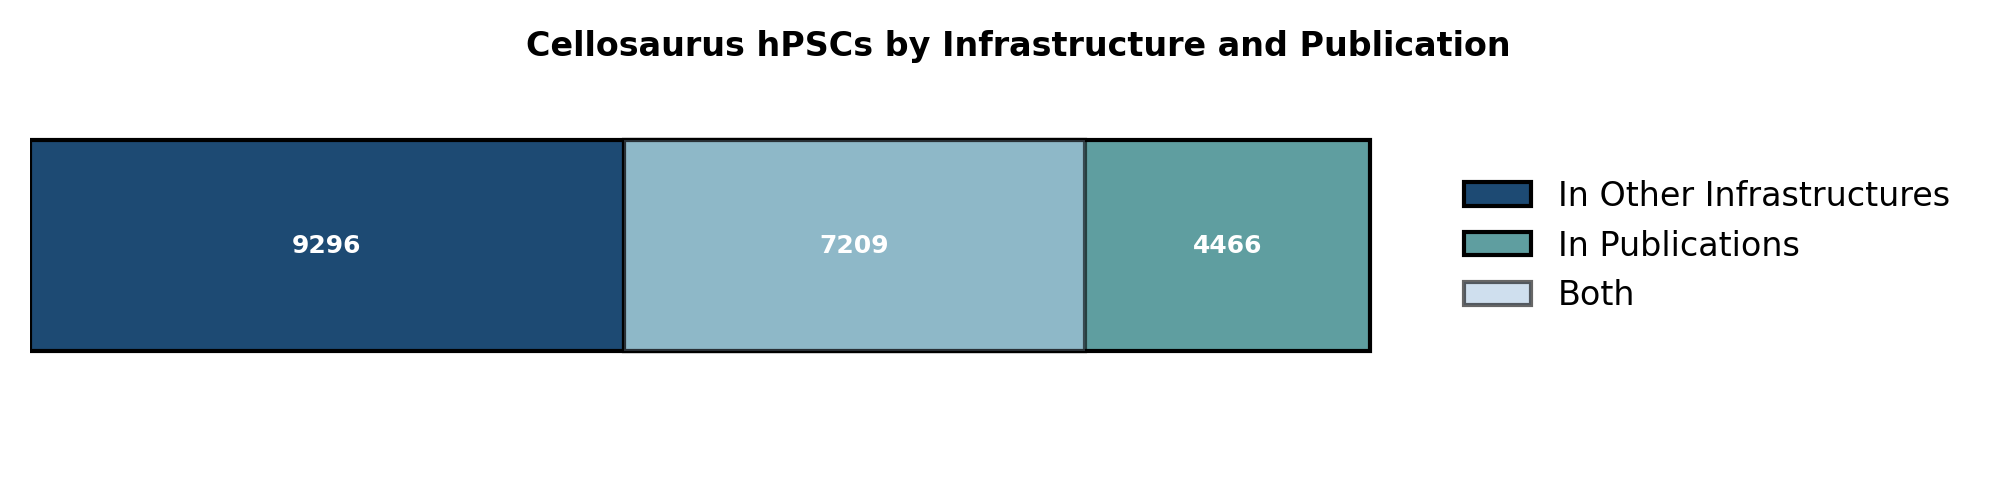

In [25]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# --- Your counts from the DataFrame ---
only_published = grouped.get((True, False), 0)
only_registered = grouped.get((False, True), 0)
both = grouped.get((True, True), 0)



# --- Normalize widths for visual scaling ---
unit = 5
reg_total = only_registered + both
pub_total = only_published + both

reg_width = reg_total / unit
pub_width = pub_total / unit
height = 2

# --- Set up the figure ---
fig_width_inch = 175 / 25.4
fig_height_inch = 50 / 25.4

# Set up the figure and layout
fig = plt.figure(figsize=(fig_width_inch, fig_height_inch), dpi=300)
ax = fig.add_subplot(111)  # Create a single subplot that fills the figure
ax.axis('off')             # Now it's safe to turn off the axis


# --- Coordinates for overlap ---
overlap_start = reg_width - (both / unit)
overlap_width = both / unit

# --- Draw rectangles ---
ax.add_patch(Rectangle((0, 1), reg_width, height, facecolor='#1D4A73', edgecolor='black', label='In Other Infrastructures'))
ax.add_patch(Rectangle((overlap_start, 1), pub_width, height, facecolor='cadetblue', edgecolor='black', label='In Publications'))
ax.add_patch(Rectangle((overlap_start, 1), overlap_width, height, facecolor='#AFCBE3', edgecolor='black', alpha=0.6, label = 'Both'))  # Overlap

# --- Centered text inside each region ---
ax.text(reg_width / 2 - overlap_width / 2, 2, only_registered, ha='center', va='center', fontsize=6, color='white', fontweight='bold')
ax.text(reg_width + (pub_width - overlap_width) / 2, 2, only_published, ha='center', va='center', fontsize=6, color='white', fontweight='bold')
ax.text(overlap_start + overlap_width / 2, 2, both, ha='center', va='center', fontsize=6, color='white', fontweight='bold')

# --- Legend on the right ---
ax.legend(loc='center left', bbox_to_anchor=(0.78, 0.5), fontsize=8, frameon=False)

# --- Title ---
fig.suptitle('Cellosaurus hPSCs by Infrastructure and Publication', fontsize=8, fontweight='bold', y=0.8, ha='center')


# --- Axes limits ---
ax.set_xlim(0, reg_width + pub_width)
ax.set_ylim(0, 4)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

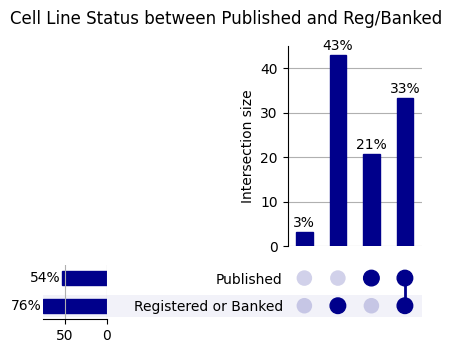

In [26]:
plot(df_agg_percentage, facecolor = 'darkblue', show_counts = '%.0f%%', sort_by="degree")
plt.suptitle("Cell Line Status between Published and Reg/Banked")
plt.show()

# Check the year of data entry for each subset

In [29]:
# Extract the last two digits of the year from the "Created" date in 'DT' and create a new column
df['Date of Entry'] = pd.to_numeric(df['DT'].str.extract(r'Created: \d{2}-\d{2}-(\d{2})')[0])

In [30]:
#df.to_excel(os.path.join(data_dir, 'Year', 'Date.xlsx'), index=False)

#Figures - Venne Diagram

In [69]:
pip install matplotlib-venn


# Date of Entry

In [32]:
# Define a function to calculate and display statistics for a subset
def calculate_statistics(subset_df, label):
    # Ensure we are working with the specific column, 'Date of Entry'
    if 'Date of Entry' in subset_df:
        data = subset_df['Date of Entry']

        # Calculate mean, median, standard deviation, and IQR
        mean_value = data.mean()
        median_value = data.median()
        std_dev = data.std()
        iqr = data.quantile(0.75) - data.quantile(0.25)  # Calculate IQR as Q3 - Q1

        # Display the results for this subset
        print(f"\nStatistics for {label}:")
        print(f"Mean: {mean_value}")
        print(f"Median: {median_value}")
        print(f"Standard Deviation: {std_dev}")
        print(f"Interquartile Range (IQR): {iqr}")
    else:
        print(f"\n'{label}' subset does not contain 'Date of Entry' column.")

none_three = df[(~df['Published']) & (~df['Registered']) & (~df['Banked'])]

registered = df[df['Registered']]
published = df[df['Published']]
banked = df[df['Banked']]

# Calculate and display statistics for each subset
# big three groups
calculate_statistics(published, "Published")
calculate_statistics(registered, "Registered")
calculate_statistics(banked, "Banked")

calculate_statistics(only_published, "Only Published")
calculate_statistics(only_registered, "Only Registered")
calculate_statistics(only_banked, "Only Banked")
calculate_statistics(published_registered, "Published and Registered")
calculate_statistics(published_banked, "Published and Banked")
calculate_statistics(registered_banked, "Registered and Banked")
calculate_statistics(all_three, "All Three")
calculate_statistics(none_three, "None Three")


Statistics for Published:
Mean: 18.518715203426122
Median: 20.0
Standard Deviation: 3.3475084734709593
Interquartile Range (IQR): 5.0

Statistics for Registered:
Mean: 18.249082849281564
Median: 18.0
Standard Deviation: 3.363971845990274
Interquartile Range (IQR): 5.0

Statistics for Banked:
Mean: 18.02724892908139
Median: 17.0
Standard Deviation: 2.75075876921388
Interquartile Range (IQR): 4.0


TypeError: argument of type 'numpy.int64' is not iterable

# Figures - Banks & Registries

# lines are registered:  13084
# lines are banked:  8404
# lines are registered or banked:  16505
hPSCreg    9860
SKIP       4916
RCB        2174
Coriell    1964
ECACC      1772
FCDI       1618
WiCell     1504
EBiSC      1223
HipSci     1221
NIHhESC     503
NHCDR       338
RSCB        123
BCRC         99
JCRB         23
ATCC         20
dtype: int64


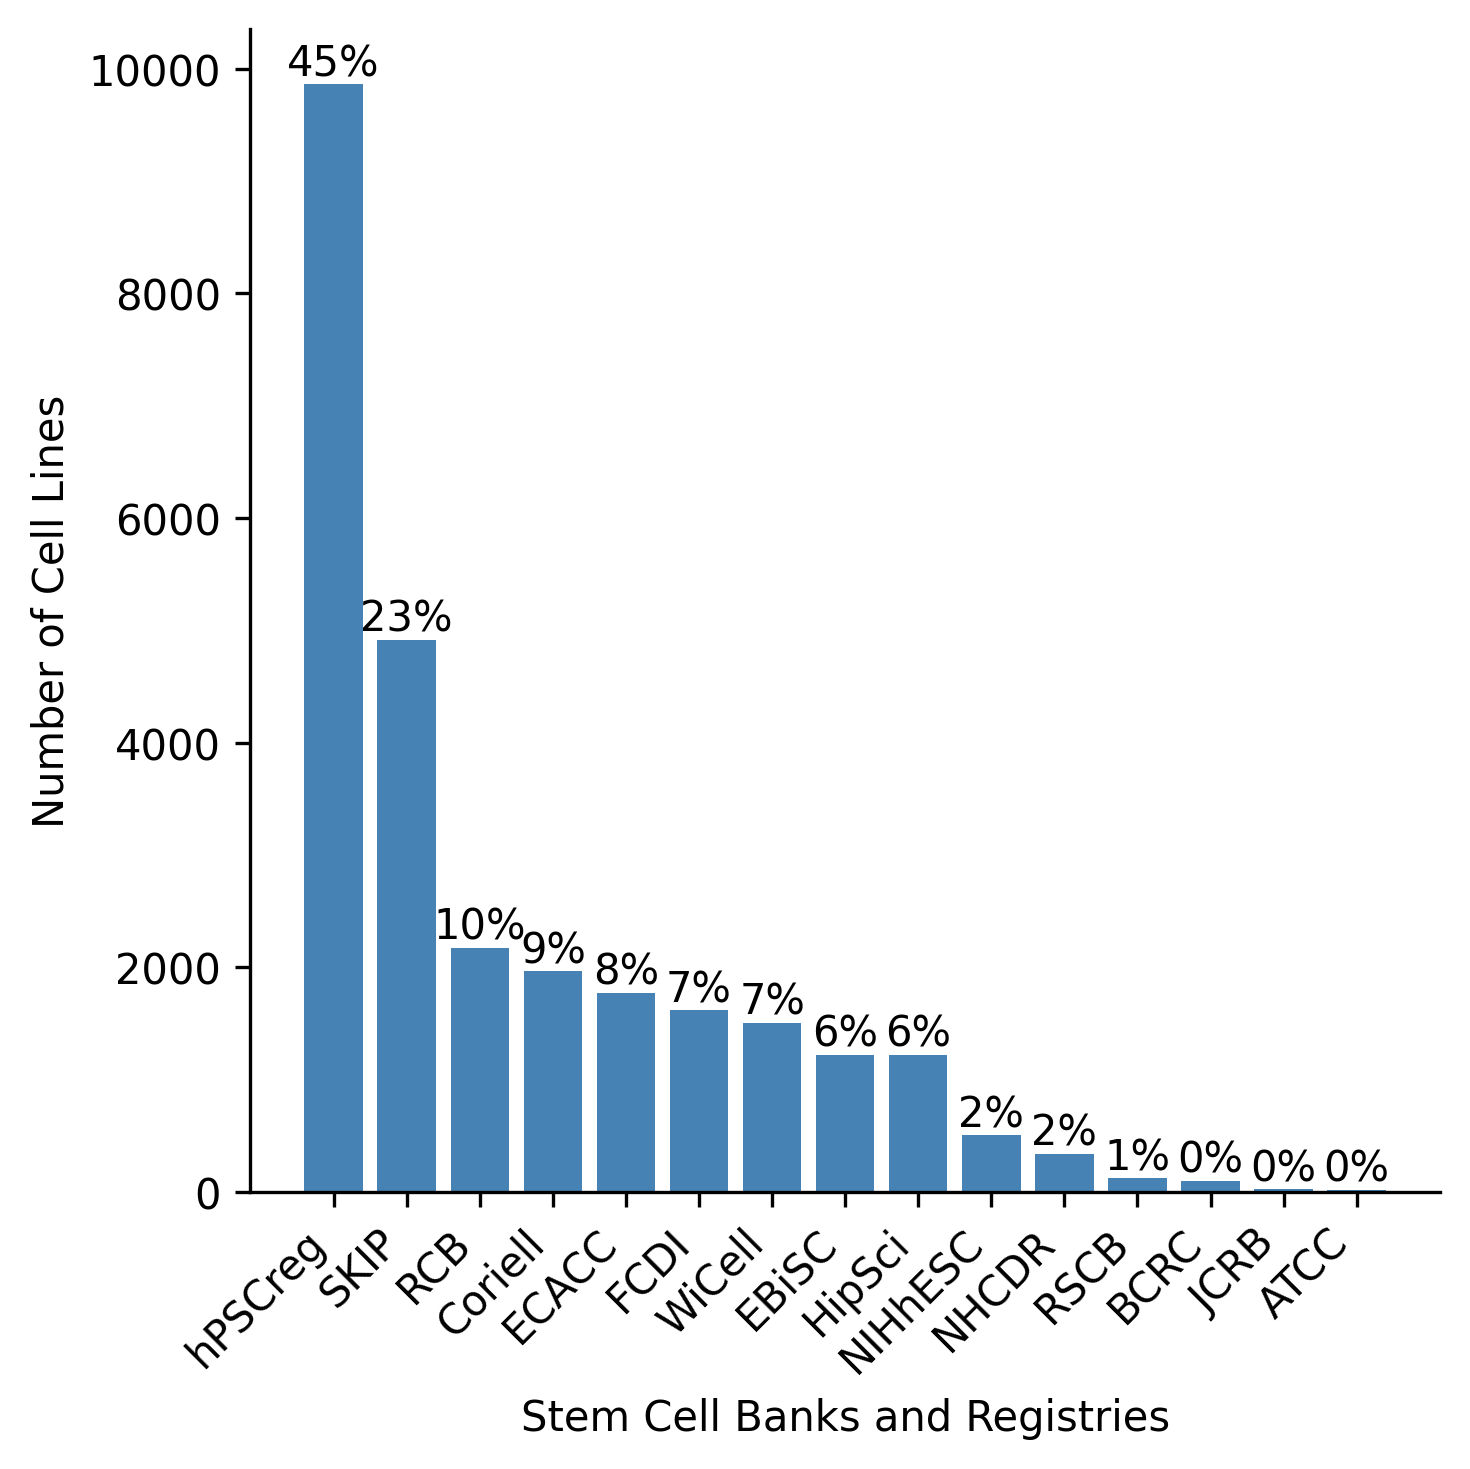

In [55]:
# Filter the columns in df based on 'Category' column in lookup_df
filtered_lookup_df = lookup_df[lookup_df['Category'].isin(['Bank', 'Registry'])]

# remove CCRID and CancerTools
#filtered_lookup_df = filtered_lookup_df[~filtered_lookup_df['Abbreviation'].isin(['CCRID','CancerTools'])]

lookup_dict = filtered_lookup_df.set_index('Abbreviation')['Category'].to_dict()

print('# lines are registered: ', df['Registered'].sum())
print('# lines are banked: ', df['Banked'].sum())
print('# lines are registered or banked: ', df['Registered or Banked'].sum())

# Filter columns in the DataFrame based on the keys in the lookup dictionary
filtered_df = df[lookup_dict.keys()]

# Sample data
yes_counts = filtered_df.eq('yes').sum().sort_values(ascending = False)
print(yes_counts)

# Remove the last 3 entries from yes_count
#yes_counts = yes_counts[:-3]

# Calculate total count
total_count = 21674

# Create a histogram
plt.figure(figsize=(5, 5), dpi=300)
plt.bar(yes_counts.index, yes_counts.values, color = 'steelblue')

# Add percentage labels to each bar
for i, count in enumerate(yes_counts):
    percentage = count / total_count * 100
    plt.text(i, count, f'{percentage:.0f}%', ha='center', va='bottom')

# Remove top and right edges (spines)
ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Stem Cell Banks and Registries')
plt.ylabel('Number of Cell Lines')
#plt.title('Cell Line Coverage Across Banks or Registries')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [83]:
print(yes_counts)

hPSCreg    9860
SKIP       4916
RCB        2174
Coriell    1964
ECACC      1772
FCDI       1618
WiCell     1504
EBiSC      1223
HipSci     1221
NIHhESC     503
NHCDR       338
RSCB        123
BCRC         99
JCRB         23
ATCC         20
dtype: int64


In [1]:
count = df[['hPSCreg', 'SKIP']].eq('yes').any(axis=1).sum()
print(f"Number of entries with at least one 'yes': {count}")


NameError: name 'df' is not defined

In [85]:
count = df[['RCB', 'Coriell', 'ECACC', 'FCDI', 'WiCell', 'EBiSC', 'HipSci', 'NHCDR', 'RSCB', 'BCRC', 'JCRB', 'ATCC']].eq('yes').any(axis=1).sum()
print(f"Number of entries with at least one 'yes': {count}")

Number of entries with at least one 'yes': 8404


In [80]:
# Step 1: Convert 'yes' to True, everything else (including NaN) to False
binary_df = filtered_df.eq('yes').fillna(False)

# ✅ Step 2: Drop rows where all values are False (i.e., no 'yes' in any infra)
filtered_df = filtered_df[binary_df.any(axis=1)]
binary_df = binary_df[binary_df.any(axis=1)]  # keep rows in sync


/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

<Figure size 2400x1500 with 0 Axes>

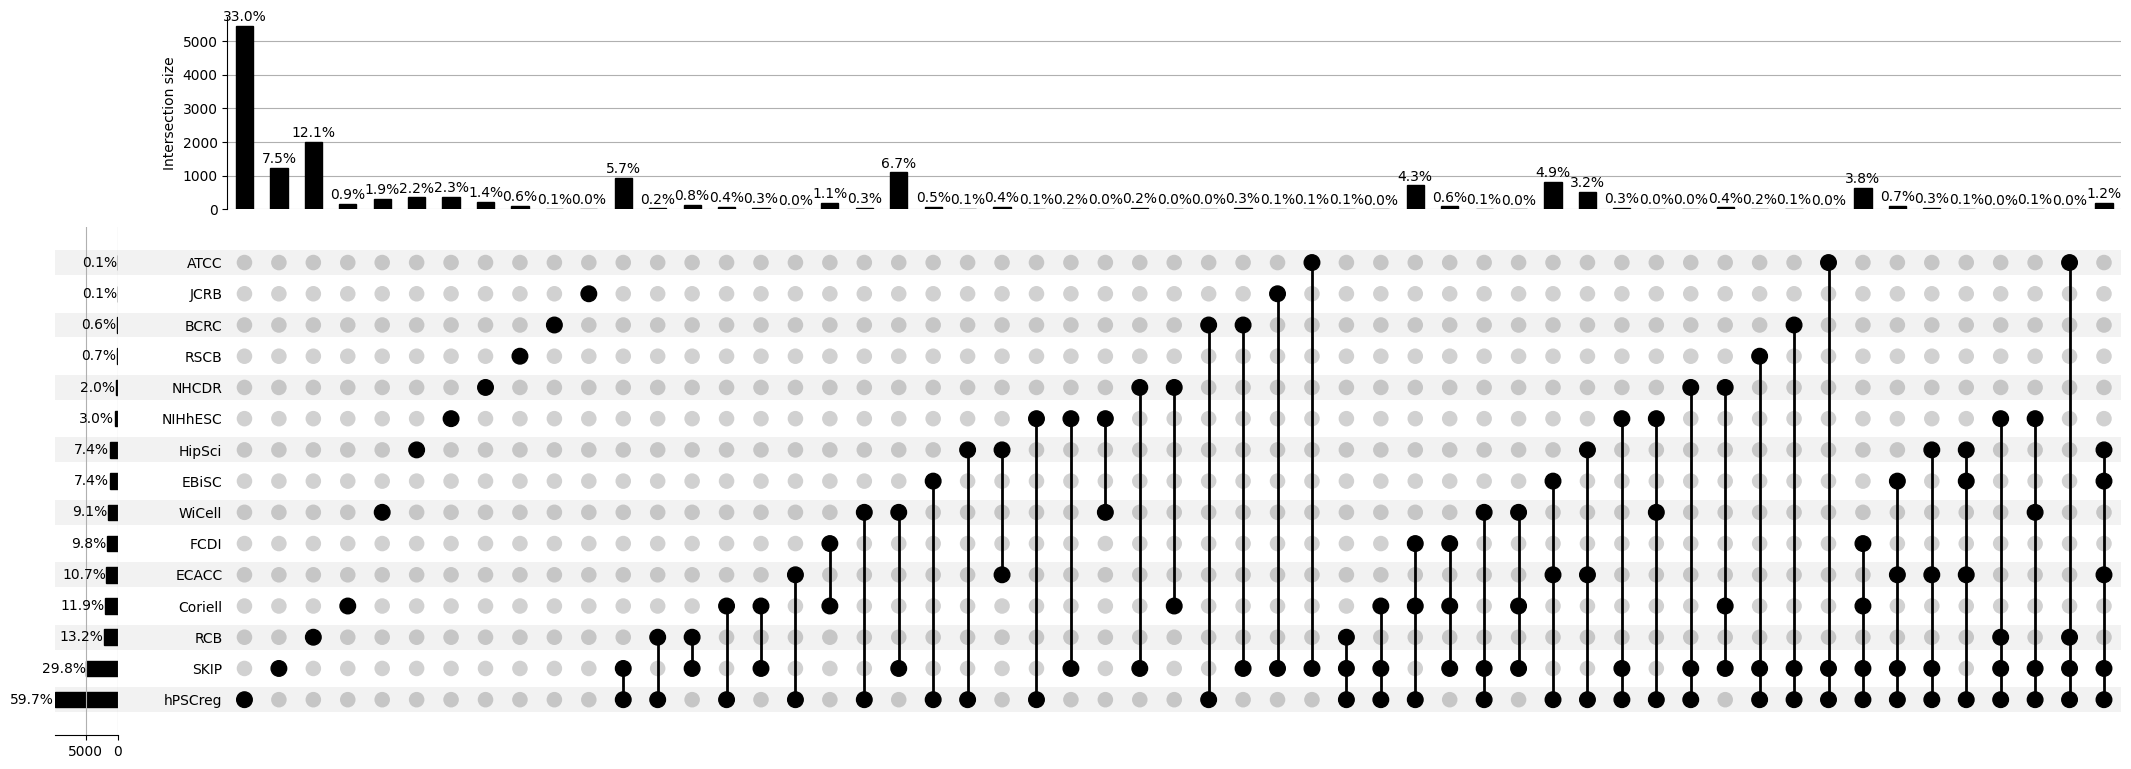

In [81]:
from upsetplot import from_indicators, UpSet
import matplotlib.pyplot as plt

# Create UpSet input
upset_data = from_indicators(binary_df)

# Plot
plt.figure(figsize=(8, 5), dpi=300)
upset = UpSet(upset_data, subset_size='count', show_percentages=True)
upset.plot()
plt.tight_layout()
plt.show()


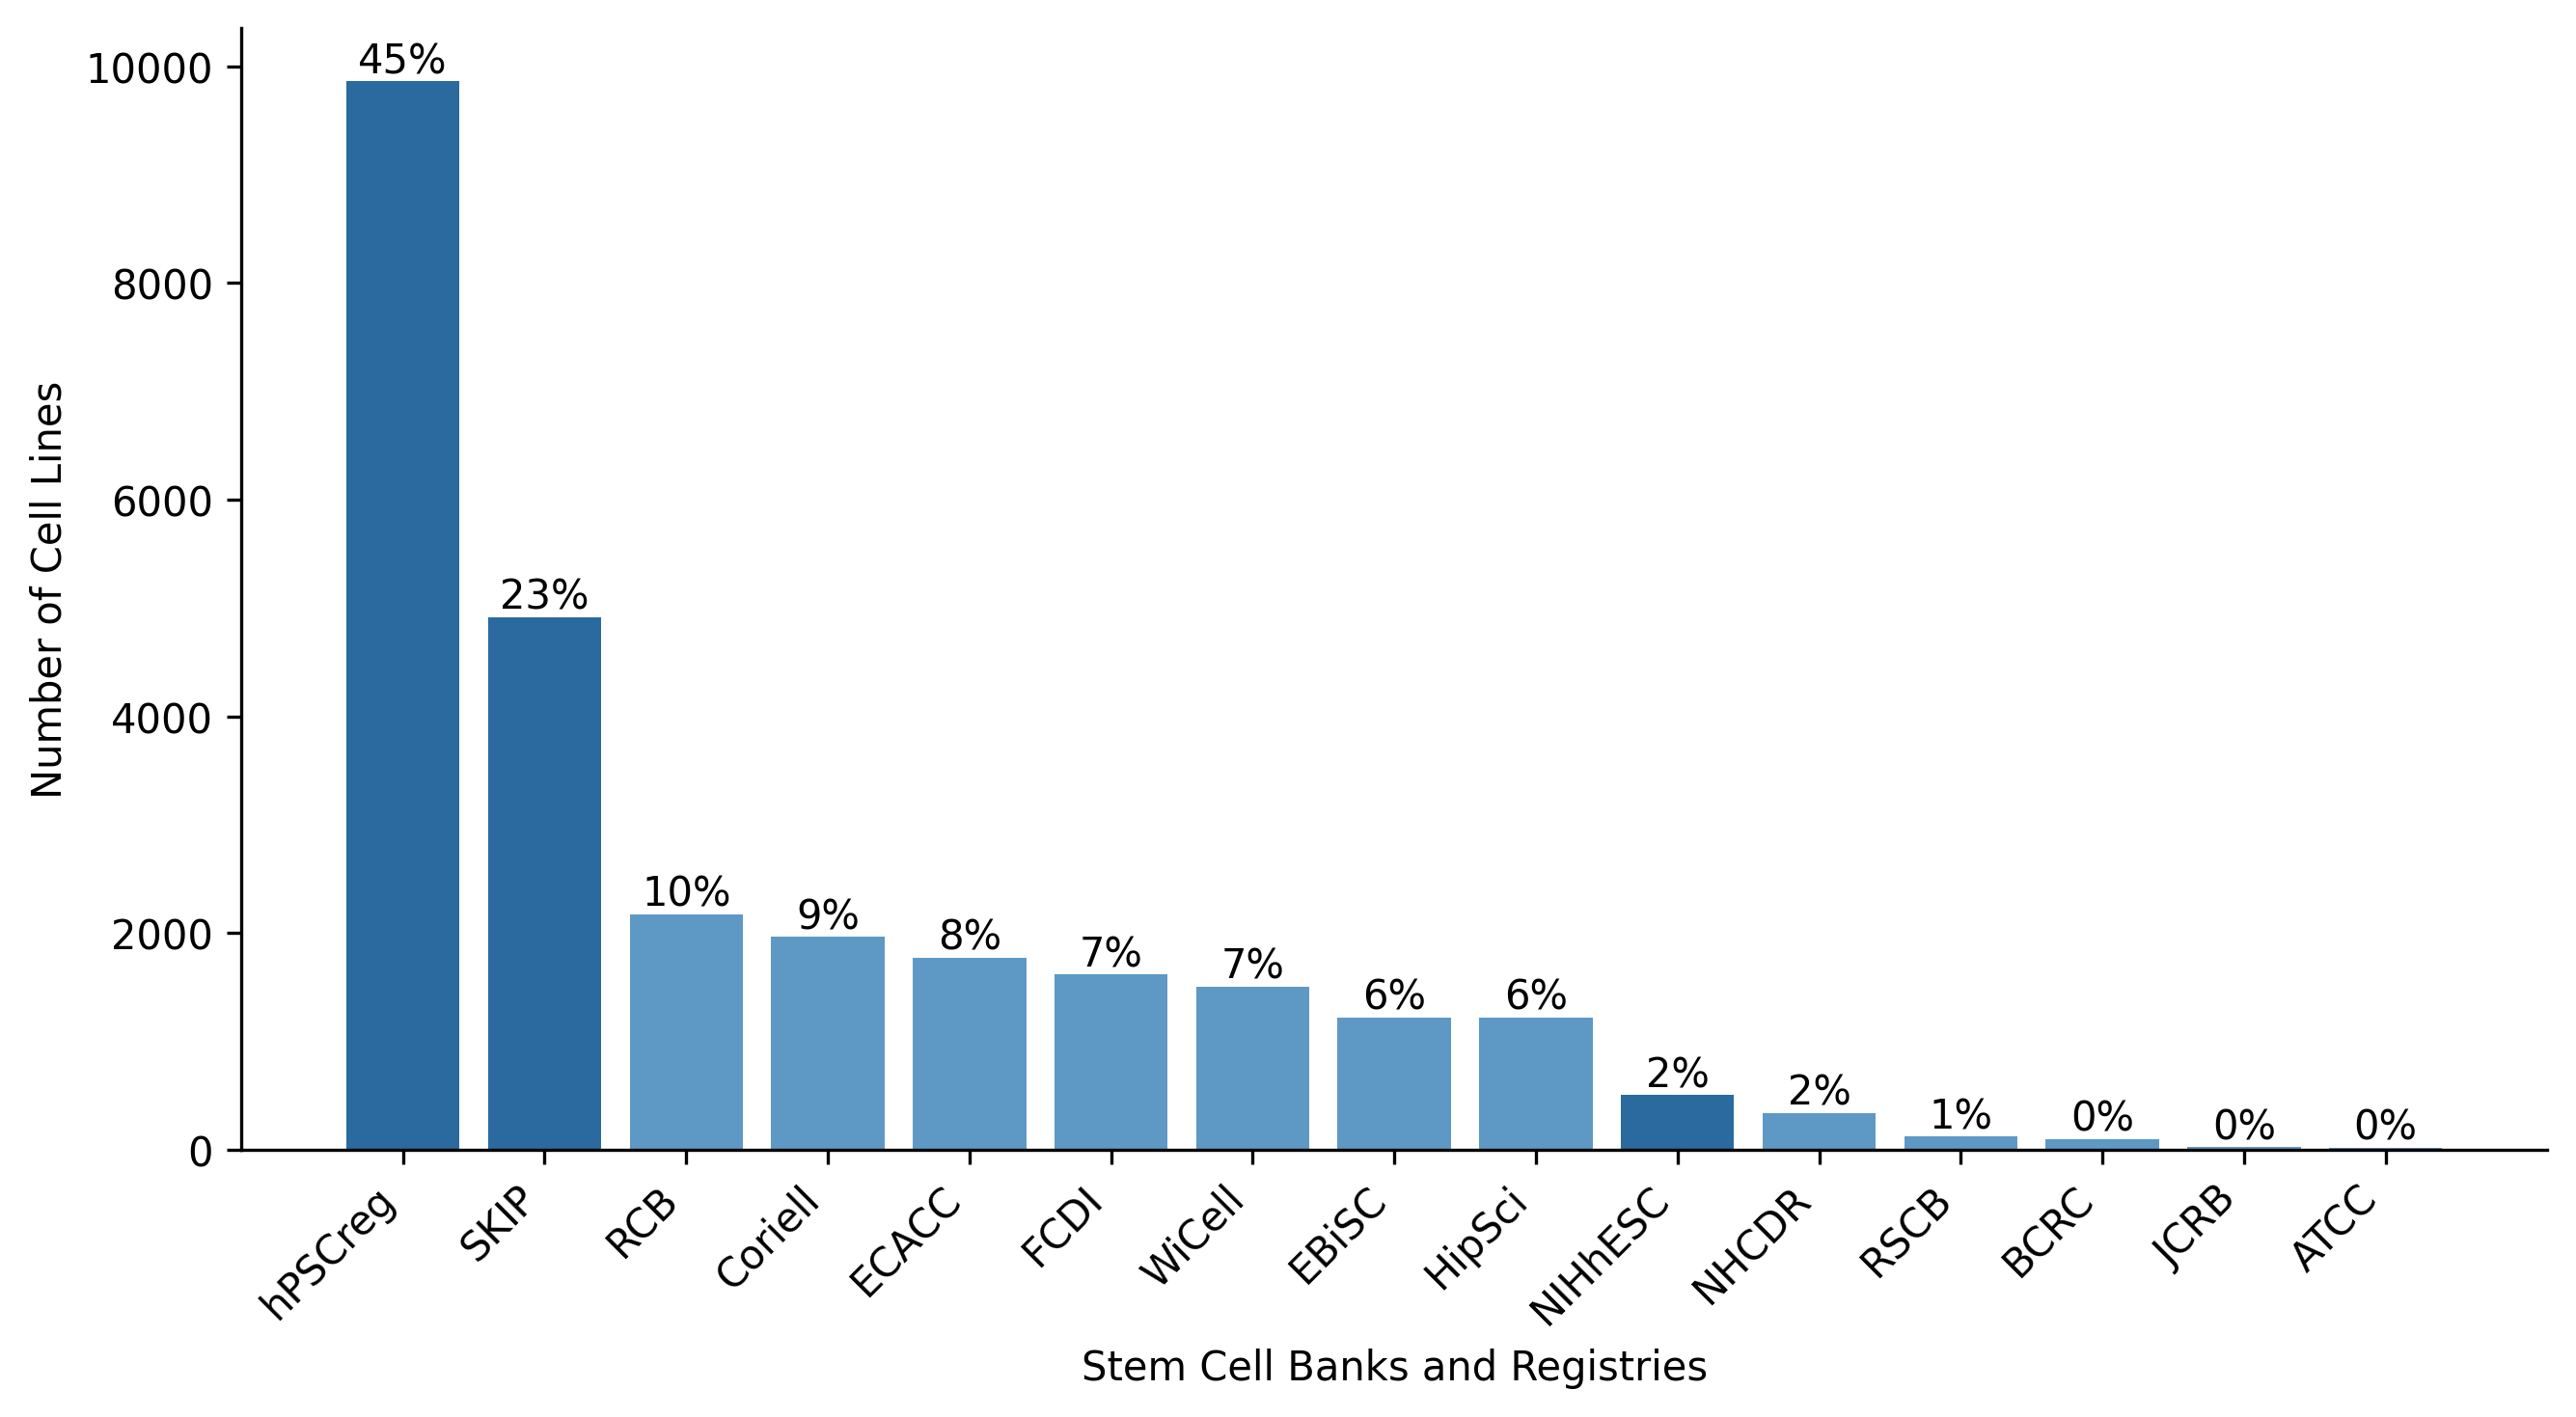

In [56]:
import matplotlib.pyplot as plt

# Define colors for different categories
category_colors = {'Bank': '#5E99C5', 'Registry': '#2A6A9E'}  # Steel Blue for Banks, Warm Yellow for Registries

# Get categories for each abbreviation
bar_colors = [category_colors[lookup_dict[col]] for col in yes_counts.index]  # Assign colors dynamically

# Create a histogram
plt.figure(figsize=(9, 5), dpi=300)
plt.bar(yes_counts.index, yes_counts.values, color=bar_colors)  # Apply category-specific colors

# Add percentage labels to each bar
for i, count in enumerate(yes_counts):
    percentage = count / total_count * 100
    plt.text(i, count, f'{percentage:.0f}%', ha='center', va='bottom')

# Remove top and right edges (spines)
ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Stem Cell Banks and Registries')
plt.ylabel('Number of Cell Lines')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [68]:
count = df[['hPSCreg', 'NIHhESC', 'SKIP']].apply(lambda row: 'yes' in row.values, axis=1).sum()
print(f"Number of records with at least one 'yes': {count}")


Number of records with at least one 'yes': 13084


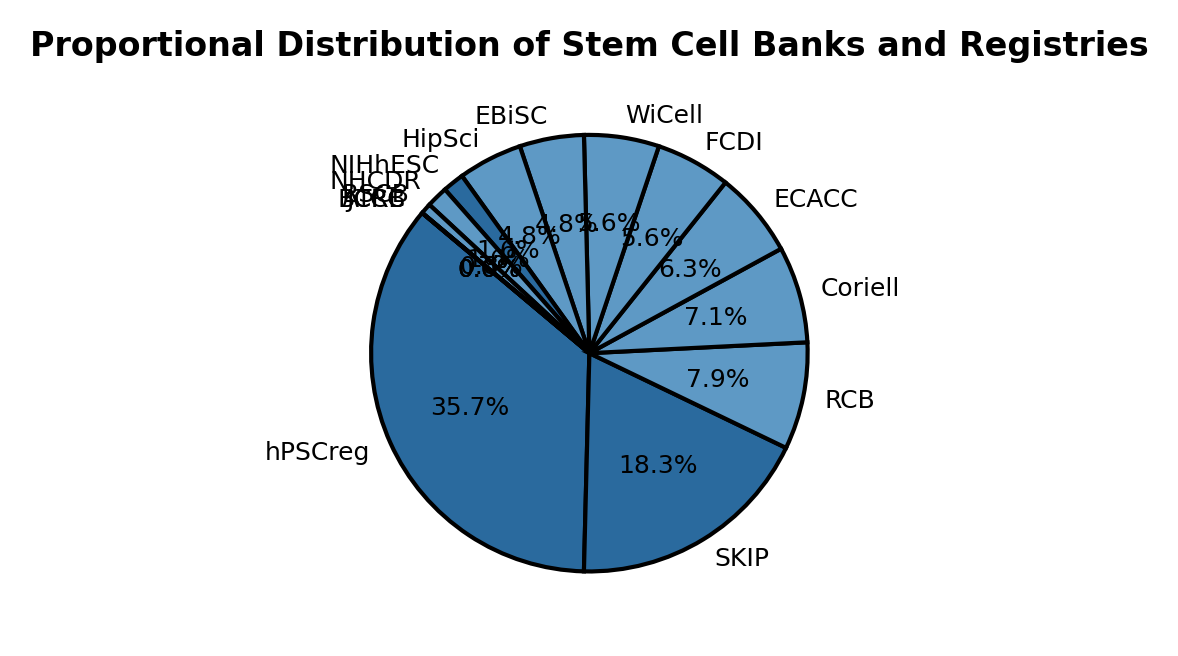

In [67]:
import matplotlib.pyplot as plt
fig_width_inch = 85 / 25.4
fig_height_inch = 60 / 25.4

# Data from the bar plot (Replace with actual values if needed)
labels = ['hPSCreg', 'SKIP', 'RCB', 'Coriell', 'ECACC', 'FCDI', 'WiCell', 'EBiSC', 'HipSci', 'NIHhESC', 'NHCDR', 'RSCB', 'BCRC', 'JCRB', 'ATCC']
values = [45, 23, 10, 9, 8, 7, 7, 6, 6, 2, 2, 1,0,0,0]  # Example values from bar plot

# Define colors for different categories
category_colors = {'Bank': '#5E99C5', 'Registry': '#2A6A9E'}  # Steel Blue for Banks, Dark Blue for Registries

# Assign colors dynamically based on category in lookup_dict
# Filter the columns in df based on 'Category' column in lookup_df
filtered_lookup_df = lookup_df[lookup_df['Category'].isin(['Bank', 'Registry'])]
filtered_lookup_dict = dict(zip(filtered_lookup_df['Abbreviation'], filtered_lookup_df['Category']))

colors = [category_colors[filtered_lookup_dict[label]] for label in labels]  # Ensure correct mapping

# Normalize values to make percentages sum to 100%
normalized_values = [v / sum(values) for v in values]

# Create pie chart with different colors for Banks and Registries
fig = plt.figure(figsize=(fig_width_inch, fig_height_inch), dpi=300)
plt.pie(
    normalized_values,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 6},
    labeldistance=1.1  # Move labels slightly further out
)


# Set title
plt.title("Proportional Distribution of Stem Cell Banks and Registries", fontsize = 8, fontweight='bold')

# Show plot
plt.show()


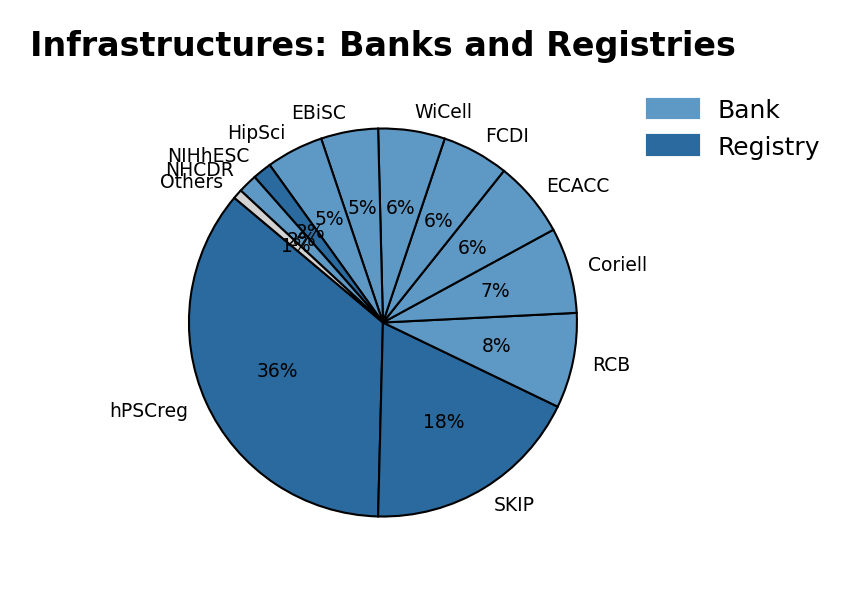

In [66]:
import matplotlib.pyplot as plt

# --- Figure size ---
fig_width_inch = 85 / 25.4
fig_height_inch = 53 / 25.4

# --- Original data ---
labels = ['hPSCreg', 'SKIP', 'RCB', 'Coriell', 'ECACC', 'FCDI', 'WiCell',
          'EBiSC', 'HipSci', 'NIHhESC', 'NHCDR', 'RSCB', 'BCRC', 'JCRB', 'ATCC']
values = [45, 23, 10, 9, 8, 7, 7, 6, 6, 2, 2, 1,0,0,0]

# --- Combine the last three into "Other Registries" ---
to_merge = ['RSCB', 'BCRC', 'JCRB', 'ATCC']
merged_label = 'Others'
combined_value = sum([values[labels.index(name)] for name in to_merge])

# Create new label and value lists
merged_labels = [label for label in labels if label not in to_merge]
merged_values = [values[i] for i, label in enumerate(labels) if label not in to_merge]
merged_labels.append(merged_label)
merged_values.append(combined_value)

# --- Define colors for categories ---
category_colors = {'Bank': '#5E99C5', 'Registry': '#2A6A9E'}


# Filter lookup_df to get categories
filtered_lookup_df = lookup_df[lookup_df['Category'].isin(['Bank', 'Registry'])]
filtered_lookup_dict = dict(zip(filtered_lookup_df['Abbreviation'], filtered_lookup_df['Category']))

# Add merged label as Bank (as per your request)
filtered_lookup_dict[merged_label] = 'Bank'

# Assign colors based on updated labels

grey_color = 'lightgrey'       # color for 'Others'

colors = [grey_color if label == 'Others' else category_colors[filtered_lookup_dict[label]]
    for label in merged_labels]
# Normalize for pie chart
normalized_values = [v / sum(merged_values) for v in merged_values]

# --- Plot pie chart ---
fig = plt.figure(figsize=(fig_width_inch, fig_height_inch), dpi=300)
plt.pie(
    normalized_values,
    labels=merged_labels,
    colors=colors,
    autopct='%1.0f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black', 'linewidth':0.5},
    textprops={'fontsize': 4.5},
    #labeldistance=1.1
)

# --- Title ---
plt.title("Infrastructures: Banks and Registries", fontsize=8, fontweight='bold')

# --- Legend ---
import matplotlib.patches as mpatches

# Define legend handles manually
legend_handles = [
    mpatches.Patch(color=category_colors['Bank'], label='Bank'),
    mpatches.Patch(color=category_colors['Registry'], label='Registry')
    #mpatches.Patch(color=grey_color, label='Others')
]

# Add the legend to the plot
plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.9), fontsize=6, frameon=False)

# --- Show plot ---
plt.tight_layout()
plt.show()


# Tables - field completeness

* Load the original Cellosaurus file

In [38]:
Cello_df = pd.read_excel(os.path.join(processed_dir, 'hPSC Cellosaurus.xlsx'))
Cello_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21674 entries, 0 to 21673
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   AC      21674 non-null  object
 1   ID      21674 non-null  object
 2   SY      15411 non-null  object
 3   DR      21627 non-null  object
 4   RX      11675 non-null  object
 5   CC      21653 non-null  object
 6   OX      21674 non-null  object
 7   HI      5341 non-null   object
 8   CA      21674 non-null  object
 9   DT      21674 non-null  object
 10  WW      2144 non-null   object
 11  SX      20936 non-null  object
 12  AG      20178 non-null  object
 13  DI      10510 non-null  object
 14  ST      1213 non-null   object
 15  OI      6814 non-null   object
 16  AS      35 non-null     object
dtypes: object(17)
memory usage: 2.8+ MB


* Write a function to extract subfields in 'CC' field

In [39]:
# Function to safely parse the 'CC' column
def safe_literal_eval(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return None

def parse_cc(cc_value):
    if pd.isna(cc_value):
        return {}

    cc_list = safe_literal_eval(cc_value)

    if cc_list is None:
        # If it's not a valid list, treat it as a single string entry
        cc_list = [cc_value]

    parsed_dict = {}

    for item in cc_list:
        if ':' in item:
            key, value = item.split(':', 1)
            key = key.strip()
            value = value.strip().strip('.')

            # Update dictionary
            if key not in parsed_dict:
                parsed_dict[key] = value
            else:
                if isinstance(parsed_dict[key], list):
                    parsed_dict[key].append(value)
                else:
                    parsed_dict[key] = [parsed_dict[key], value]

    return parsed_dict

In [40]:
# Apply the function to 'CC' column and create a new DataFrame with the results
parsed_data = Cello_df['CC'].apply(parse_cc)
# Create new columns from the parsed data
parsed_df = pd.DataFrame(parsed_data.tolist()).add_prefix('CC_')
# Concatenate the original DataFrame with the new columns
result_df = pd.concat([Cello_df, parsed_df], axis=1)
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21674 entries, 0 to 21673
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   AC                         21674 non-null  object
 1   ID                         21674 non-null  object
 2   SY                         15411 non-null  object
 3   DR                         21627 non-null  object
 4   RX                         11675 non-null  object
 5   CC                         21653 non-null  object
 6   OX                         21674 non-null  object
 7   HI                         5341 non-null   object
 8   CA                         21674 non-null  object
 9   DT                         21674 non-null  object
 10  WW                         2144 non-null   object
 11  SX                         20936 non-null  object
 12  AG                         20178 non-null  object
 13  DI                         10510 non-null  object
 14  ST    

In [41]:
#result_df.to_excel(os.path.join(processed_dir, 'Cello_expansion.xlsx'), index=False) # for record keeping

## Population Diversity

In [42]:
result_df['CC_Population'].fillna('Unknown', inplace=True)

counts = result_df['CC_Population'].value_counts()
print(counts)
#counts.to_excel(os.path.join(processed_dir, 'Population.xlsx'), index=True)

CC_Population
Unknown                             11933
Caucasian                            4798
Japanese                             1089
Caucasian; British                    581
Chinese; Han                          449
                                    ...  
Caucasian; Scandinavian                 1
Caucasian; Irish/Italian                1
Caucasian; German/Swedish               1
Caribbean; Haitian and Caucasian        1
Kazakh                                  1
Name: count, Length: 148, dtype: int64


<ipython-input-42-7fcab4c6861d>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  result_df['CC_Population'].fillna('Unknown', inplace=True)


In [43]:
# Replace values in 'CC_Population' that contain exactly two items separated by ';' with 'Multiple'
result_df['CC_Population'] = result_df['CC_Population'].apply(lambda x: 'Multiple' if len(x.split(';')) >= 2 or len(x.split('and')) >= 2 else x)


In [44]:
# Define a mapping dictionary for grouping
ancestry_mapping = {
    "Unknown": "Unkown",

    "Caucasian": "European/Caucasian",
    "Caucasian, not Hispanic": "European/Caucasian",
    "Jewish": "European/Caucasian",
    "Turkish": "European/Caucasian",
    "Iranian": "European/Caucasian",

    "Chinese": "East Asian",
    "Japanese": "East Asian",
    "Korean": "East Asian",
    "East Asian": "East Asian",
    "Mongolian": "East Asian",
    "Ryukyuan": "East Asian",
    "Chinese/Asian ethnic group: Hui": "East Asian",
    "Chinese/Asian ethnic group: Uyghur": "East Asian",

    "Indian": "South Asian",
    "Pakistani": "South Asian",
    "Bangladeshi": "South Asian",
    "Nepali": "South Asian",
    "East Indian": "South Asian",
    "Bengali": "South Asian",
    "Afghan": "South Asian",

    "African American": "African",
    "African": "African",
    "Lybian": "African",
    "Egyptian": "African",
    "Moroccan": "African",
    "Cape Verdian": "African",
    "Bedouin": "African",
    "Afro-Brazilian": "African",
    "Black or African American": "African",

    "Arab": "Middle Eastern/Arab",
    "Saudi Arabian": "Middle Eastern/Arab",
    "Jordanian": "Middle Eastern/Arab",
    "Palestinian": "Middle Eastern/Arab",
    "Iraqi": "Middle Eastern/Arab",
    "Bahraini": "Middle Eastern/Arab",
    "Lebanese": "Middle Eastern/Arab",
    "Middle Eastern": "Middle Eastern/Arab",
    "Israeli": "Middle Eastern/Arab",
    "Tunisian": "Middle Eastern/Arab",

    "Latino or Hispanic": "Latin American/Hispanic",
    "Hispanic": "Latin American/Hispanic",
    "Latino": "Latin American/Hispanic",
    "Mexican": "Latin American/Hispanic",
    "Brazilian": "Latin American/Hispanic",
    "Puerto Rican": "Latin American/Hispanic",
    "Chilean": "Latin American/Hispanic",
    "South American (Brazil, Guyana, Venezuela)": "Latin American/Hispanic",
    "Cuban": "Latin American/Hispanic",
    "Caribbean": "Latin American/Hispanic",

    "Aboriginal Australian": "Pacific/Indigenous",
    "Pacific": "Pacific/Indigenous",
    "Native North American": "Pacific/Indigenous",
    "Native American": "Pacific/Indigenous",
    # Any other unmapped values can be assigned as needed
}

# Apply the mapping
result_df['Grouped_Ancestry'] = result_df['CC_Population'].map(ancestry_mapping).fillna(result_df['CC_Population'])

# Count occurrences in each grouped category
grouped_counts = result_df['Grouped_Ancestry'].value_counts()
print(grouped_counts)

Grouped_Ancestry
Unkown                     11933
European/Caucasian          5275
Multiple                    1613
East Asian                  1406
African                      525
Asian                        355
Latin American/Hispanic      275
South Asian                  185
Middle Eastern/Arab           83
Pacific/Indigenous            19
Southeast Asian                4
Kazakh                         1
Name: count, dtype: int64


In [45]:
# Update mapping for all Asian categories to group under "Asian"
ancestry_mapping.update({
    "Asian": "Asian",
    "East Asian": "Asian",
    "Southeast Asian": "Asian",
    "South Asian": "Asian",
    "Chinese": "Asian",
    "Japanese": "Asian",
    "Korean": "Asian",
    "Mongolian": "Asian",
    "Ryukyuan": "Asian",
    "Chinese/Asian ethnic group: Hui": "Asian",
    "Chinese/Asian ethnic group: Uyghur": "Asian",
    "Indian": "Asian",
    "Pakistani": "Asian",
    "Bangladeshi": "Asian",
    "Nepali": "Asian",
    "East Indian": "Asian",
    "Bengali": "Asian",
    "Afghan": "Asian",
    "Kazakh": "Asian"
    # Add more if necessary
})

# Apply the mapping with .fillna() to keep unmatched values
result_df['Grouped_Ancestry'] = result_df['CC_Population'].map(ancestry_mapping).fillna(result_df['CC_Population'])

# Count occurrences in each grouped category
grouped_counts = result_df['Grouped_Ancestry'].value_counts()
print(grouped_counts)

Grouped_Ancestry
Unkown                     11933
European/Caucasian          5275
Asian                       1951
Multiple                    1613
African                      525
Latin American/Hispanic      275
Middle Eastern/Arab           83
Pacific/Indigenous            19
Name: count, dtype: int64


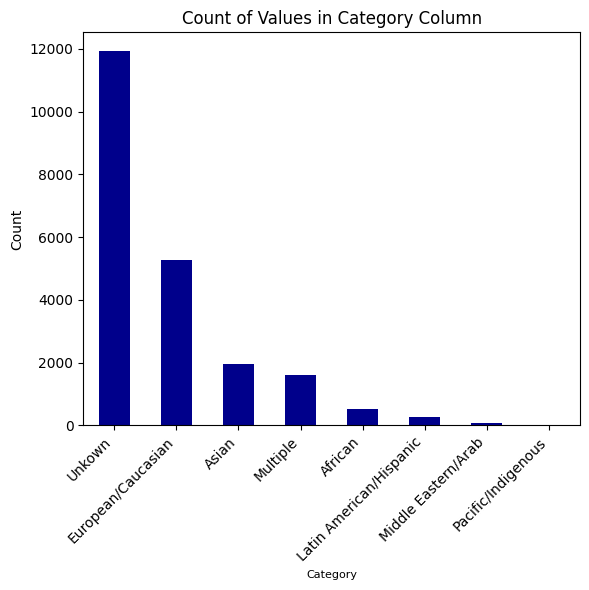

In [46]:
# Create bar plot
plt.figure(figsize=(6, 6))
grouped_counts.plot(kind='bar', color='darkblue')
plt.xlabel('Category', fontsize=8)
plt.ylabel('Count')
plt.title('Count of Values in Category Column')
plt.xticks(rotation=45, fontsize=10, ha = 'right')  # Rotate the x-axis labels for better readability
plt.tight_layout()
plt.show()

# Table values - national vs hPSCreg

In [47]:
df['Published'] = df['RX'].apply(lambda x: False if pd.isna(x) or x == '' else True)

## Japan

- Total

In [48]:
# National Coverage
total = len(df[df['Region'] == 'Japan'])
print(total)

national_coverage = len(df[(df['Region'] == 'Japan') & ((df['RCB'] == 'yes') | (df['JCRB'] == 'yes') | (df['SKIP'] == 'yes'))])
print(f'National Coverage: {national_coverage/total*100:.0f}%')

hPSCreg_coverage = len(df[(df['Region'] == 'Japan') & (df['hPSCreg'] == 'yes')])
print(f'hPSCreg Coverage: {hPSCreg_coverage/total*100:.0f}%')

3004
National Coverage: 84%
hPSCreg Coverage: 12%


- unpublished

In [49]:
# National Coverage
total = len(df[(df['Region'] == 'Japan') & (df['Published'] == False)])
print(total)

national_coverage = len(df[((df['Region'] == 'Japan') & (df['Published'] == False)) & ((df['RCB'] == 'yes') | (df['JCRB'] == 'yes') | (df['SKIP'] == 'yes'))])
print(f'National Coverage: {national_coverage/total*100:.0f}%')

hPSCreg_coverage = len(df[((df['Region'] == 'Japan') & (df['Published'] == False)) & (df['hPSCreg'] == 'yes')])
print(f'hPSCreg Coverage: {hPSCreg_coverage/total*100:.0f}%')

2221
National Coverage: 95%
hPSCreg Coverage: 6%


## USA

- Total

In [50]:
# National Coverage
total = len(df[df['Region'] == 'USA'])
print(total)

national_coverage = len(df[(df['Region'] == 'USA') & ((df['Coriell'] == 'yes') | (df['FCDI'] == 'yes') | (df['WiCell'] == 'yes') | (df['NHCDR'] == 'yes') | (df['ATCC'] == 'yes') | (df['NIHhESC'] == 'yes'))])
print(f'National Coverage: {national_coverage/total*100:.0f}%')

hPSCreg_coverage = len(df[(df['Region'] == 'USA') & (df['hPSCreg'] == 'yes')])
print(f'hPSCreg Coverage: {hPSCreg_coverage/total*100:.0f}%')

6446
National Coverage: 62%
hPSCreg Coverage: 44%


- unpublished

In [51]:
# National Coverage
total = len(df[(df['Region'] == 'USA') & (df['Published'] == False)])
print(total)

national_coverage = len(df[((df['Region'] == 'USA') & (df['Published'] == False)) & ((df['Coriell'] == 'yes') | (df['FCDI'] == 'yes') | (df['WiCell'] == 'yes') | (df['NHCDR'] == 'yes') | (df['ATCC'] == 'yes') | (df['NIHhESC'] == 'yes'))])
print(f'National Coverage: {national_coverage/total*100:.0f}%')

hPSCreg_coverage = len(df[((df['Region'] == 'USA') & (df['Published'] == False)) & (df['hPSCreg'] == 'yes')])
print(f'hPSCreg Coverage: {hPSCreg_coverage/total*100:.0f}%')

4203
National Coverage: 72%
hPSCreg Coverage: 48%


## Europe

- Total

In [52]:
# National Coverage
total = len(df[(df['Region'] == 'EU') | (df['Region'] == 'UK')])
print(total)

national_coverage = len(df[((df['Region'] == 'EU') | (df['Region'] == 'UK')) & ((df['ECACC'] == 'yes') | (df['EBiSC'] == 'yes') | (df['hPSCreg'] == 'yes') | (df['HipSci'] == 'yes'))])
print(f'National Coverage: {national_coverage/total*100:.0f}%')

hPSCreg_coverage = len(df[((df['Region'] == 'EU') | (df['Region'] == 'UK')) & (df['hPSCreg'] == 'yes')])
print(f'hPSCreg Coverage: {hPSCreg_coverage/total*100:.0f}%')

0


ZeroDivisionError: division by zero

- Unpublished

In [53]:
# National Coverage
total = len(df[((df['Region'] == 'EU') | (df['Region'] == 'UK')) & (df['Published'] == False)])
print(total)

national_coverage = len(df[(((df['Region'] == 'EU') | (df['Region'] == 'UK')) & (df['Published'] == False)) & ((df['ECACC'] == 'yes') | (df['EBiSC'] == 'yes') | (df['hPSCreg'] == 'yes') | (df['HipSci'] == 'yes'))])
print(f'National Coverage: {national_coverage/total*100:.0f}%')

hPSCreg_coverage = len(df[(((df['Region'] == 'EU') | (df['Region'] == 'UK')) & (df['Published'] == False)) & (df['hPSCreg'] == 'yes')])
print(f'hPSCreg Coverage: {hPSCreg_coverage/total*100:.0f}%')

0


ZeroDivisionError: division by zero

- EU

In [54]:
# National Coverage
total = len(df[df['Region'] == 'EU'])
print(total)

national_coverage = len(df[(df['Region'] == 'EU') & ((df['ECACC'] == 'yes') | (df['EBiSC'] == 'yes') | (df['hPSCreg'] == 'yes'))])
print(f'National Coverage: {national_coverage/total*100:.0f}%')

hPSCreg_coverage = len(df[(df['Region'] == 'EU') & (df['hPSCreg'] == 'yes')])
print(f'hPSCreg Coverage: {hPSCreg_coverage/total*100:.0f}%')

0


ZeroDivisionError: division by zero

- UK

In [ ]:
# National Coverage
total = len(df[df['Region'] == 'UK'])
print(total)

national_coverage = len(df[(df['Region'] == 'UK') & (df['HipSci'] == 'yes')])
print(f'National Coverage: {national_coverage/total*100:.0f}%')

hPSCreg_coverage = len(df[(df['Region'] == 'UK') & (df['hPSCreg'] == 'yes')])
print(f'hPSCreg Coverage: {hPSCreg_coverage/total*100:.0f}%')

## Taiwan

- Total

In [ ]:
# National Coverage
total = len(df[df['Region'] == 'Taiwan'])
print(total)

national_coverage = len(df[(df['Region'] == 'Taiwan') & (df['BCRC'] == 'yes')])
print(f'National Coverage: {national_coverage/total*100:.0f}%')

hPSCreg_coverage = len(df[(df['Region'] == 'Taiwan') & (df['hPSCreg'] == 'yes')])
print(f'hPSCreg Coverage: {hPSCreg_coverage/total*100:.0f}%')

- Unpublished

In [ ]:
# National Coverage
total = len(df[(df['Region'] == 'Taiwan') & (df['Published'] == False)])
print(total)

national_coverage = len(df[((df['Region'] == 'Taiwan') & (df['Published'] == False)) & (df['BCRC'] == 'yes')])
print(f'National Coverage: {national_coverage/total*100:.0f}%')

hPSCreg_coverage = len(df[((df['Region'] == 'Taiwan') & (df['Published'] == False)) & (df['hPSCreg'] == 'yes')])
print(f'hPSCreg Coverage: {hPSCreg_coverage/total*100:.0f}%')

## Iran

- Total

In [ ]:
# National Coverage
total = len(df[df['Region'] == 'Iran'])
print(total)

national_coverage = len(df[(df['Region'] == 'Iran') & (df['RSCB'] == 'yes')])
print(f'National Coverage: {national_coverage/total*100:.0f}%')

hPSCreg_coverage = len(df[(df['Region'] == 'Iran') & (df['hPSCreg'] == 'yes')])
print(f'hPSCreg Coverage: {hPSCreg_coverage/total*100:.0f}%')

- Unpublished

In [ ]:
# National Coverage
total = len(df[(df['Region'] == 'Iran') & (df['Published'] == False)])
print(total)

national_coverage = len(df[((df['Region'] == 'Iran') & (df['Published'] == False)) & (df['RSCB'] == 'yes')])
print(f'National Coverage: {national_coverage/total*100:.0f}%')

hPSCreg_coverage = len(df[((df['Region'] == 'Iran') & (df['Published'] == False)) & (df['hPSCreg'] == 'yes')])
print(f'hPSCreg Coverage: {hPSCreg_coverage/total*100:.0f}%')

# Australian lines

In [ ]:
aus_df = df[df['Region'] == 'Australia']

print('# Australian lines:', len(aus_df))
print('# Australian lines are registered:', aus_df['Registered'].sum())
print('# Australian lines are banked:', aus_df['Banked'].sum())
print('# Australian lines are published:', aus_df['Published'].sum())

In [ ]:
# Filter columns in the DataFrame based on the keys in the lookup dictionary
filtered_lookup_df = lookup_df[lookup_df['Category'].isin(['Bank', 'Registry'])]
filtered_lookup_dict = filtered_lookup_df.set_index('Abbreviation')['Category'].to_dict()
print(filtered_lookup_dict)

# Filter columns in the DataFrame based on the keys in the lookup dictionary
aus_filtered_df = aus_df[filtered_lookup_dict.keys()]

# Count the occurrences of 'yes' in each column
yes_counts = aus_filtered_df.eq('yes').sum()

# Sort the counts in descending order
yes_counts_sorted = yes_counts.sort_values(ascending=False)

# Filter out rows with count equal to 0
yes_counts_filtered = yes_counts_sorted[yes_counts_sorted != 0]

print(yes_counts_filtered)

In [ ]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Define your sets
hPSCreg_set = set(aus_df[aus_df['hPSCreg'] == 'yes']['AC'])
SKIP_set = set(aus_df[aus_df['SKIP'] == 'yes']['AC'])
NIHhESC_set = set(aus_df[aus_df['NIHhESC'] == 'yes']['AC'])

# Create the figure and axes
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

# Create the Venn diagram
venn = venn3([hPSCreg_set, SKIP_set, NIHhESC_set],
             set_labels=('hPSCreg', 'SKIP', 'NIHhESC'),
             ax=ax)

# Format set labels
for text in venn.set_labels:
    if text:
        text.set_fontsize(10)

# Format subset labels (counts)
for text in venn.subset_labels:
    if text:
        text.set_fontsize(10)

# Define custom fill colors
region_colors = {
    '100': '#7FA8C6',  # hPSCreg only
    '010': '#6FB0A1',  # SKIP only
    '001': '#D68C91',  # NIHhESC only
    '110': '#B0B0B0',  # hPSCreg + SKIP
    '101': '#B79FC8',  # hPSCreg + NIHhESC
    '011': '#D5B08C',  # SKIP + NIHhESC
    '111': '#AFAAA3'   # All three
}



# Apply colors and black edges safely
for region_id, color in region_colors.items():
    patch = venn.get_patch_by_id(region_id)
    if patch:
        patch.set_color(color)
        patch.set_alpha(1.0)
        patch.set_edgecolor('black')
        patch.set_linewidth(0.5)

# Add title and clean up
plt.title('Venn Diagram for Registered Australian hPSC Lines', fontsize=12)
plt.tight_layout()
plt.show()
